# 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

### Step 1. 데이터셋 내려받기
모델 학습을 위한 데이터셋(dataset) 준비하기

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
})

In [6]:
import warnings # 필요한 메시지 외 경고 메시지가 출력되지 않음
import tensorflow as tf # 텐서플로우 활용
import tensorflow_datasets as tfds # 텐서플로우가 제공하는 데이터셋 모음집
import matplotlib.pyplot as plt # 데이터를 확인하기 위해 시각화
import opendatasets as od
od.download("http://download.tensorflow.org/example_images/flower_photos.tgz")

228818944it [00:01, 178770231.66it/s]                               


In [7]:
!pip install kaggle
!mkdir -p ~/aiffel/tf_flowers/flowersImages
!pip install opendatasets
!ln -s ~/data/* ~/aiffel/tf_flowers/
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/tf_flowers/',
    download=True,
    with_info=True,
    as_supervised=True,
)

ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/cats_vs_dogs': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/my_dog.jpg': File exists


### Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

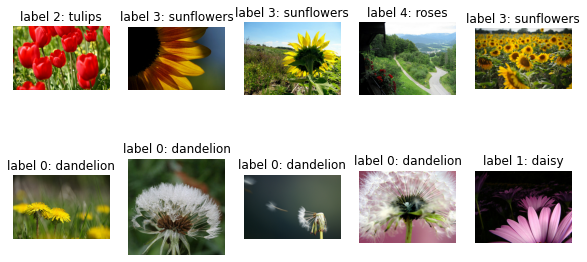

In [8]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [9]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


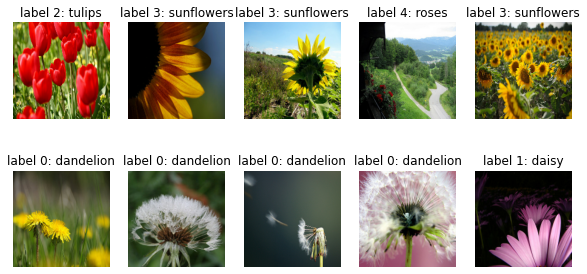

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [21]:
BATCH_SIZE = 32
train_batches = train.shuffle(1000).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batch.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

### Step 3. 모델 설계하기

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D

In [23]:
# base model로 mobilenet 사용

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                      include_top=False,
                                                      weights='imagenet')
model = Sequential([base_model,
                 GlobalAveragePooling2D(),
                 Dense(512, activation='relu'),
                 Dense(5, activation='softmax')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 2,882,309
Non-trainable params: 34,112
_________________________________________________________________


### Step 4. 모델 학습시키기

In [24]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [25]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 0s - loss: 2.2320 - accuracy: 0.1117WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 15ms/step - loss: 2.2320 - accuracy: 0.1117
initial loss: 2.23
initial accuracy: 0.11


In [26]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 27s 139ms/step - loss: 0.5197 - accuracy: 0.8147 - val_loss: 0.5643 - val_accuracy: 0.7984
Epoch 2/10
92/92 [==============================] - 12s 121ms/step - loss: 0.1322 - accuracy: 0.9530 - val_loss: 0.3632 - val_accuracy: 0.8856
Epoch 3/10
92/92 [==============================] - 12s 121ms/step - loss: 0.0686 - accuracy: 0.9758 - val_loss: 0.2806 - val_accuracy: 0.9155
Epoch 4/10
92/92 [==============================] - 12s 120ms/step - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.4698 - val_accuracy: 0.8856
Epoch 5/10
92/92 [==============================] - 11s 120ms/step - loss: 0.0280 - accuracy: 0.9911 - val_loss: 0.5476 - val_accuracy: 0.8638
Epoch 6/10
92/92 [==============================] - 11s 120ms/step - loss: 0.0265 - accuracy: 0.9925 - val_loss: 0.4634 - val_accuracy: 0.8828
Epoch 7/10
92/92 [==============================] - 12s 120ms/step - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.5614 - val_accuracy: 0.8719

### Step 5. 모델 성능 평가하기

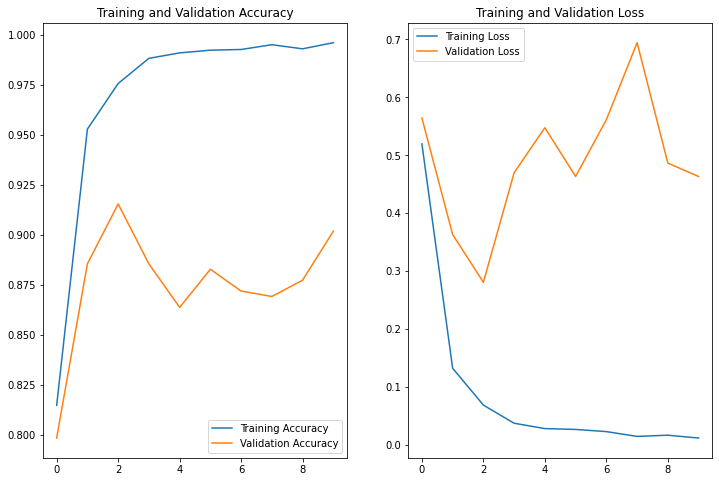

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [28]:
pred = model.predict(test_batch)
pred_label = pred.argmax(axis=1)
pred_label

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 2, 2, 3, 0, 4, 4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 2, 2,
       1, 1, 0, 0, 4, 2, 2, 0, 2, 1, 1, 2, 4, 2, 1, 2, 4, 3, 2, 1, 0, 1,
       3, 2, 3, 0, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 2, 2, 2,
       4, 1, 2, 0, 1, 1, 3, 3, 3, 3, 2, 0, 3, 2, 4, 4, 2, 0, 3, 2, 2, 1,
       2, 4, 2, 1, 4, 0, 4, 0, 1, 2, 2, 0, 4, 2, 2, 2, 3, 0, 3, 3, 0, 4,
       4, 1, 3, 3, 2, 1, 2, 4, 3, 0, 3, 2, 1, 2, 3, 0, 3, 2, 2, 4, 4, 0,
       0, 3, 2, 0, 4, 2, 2, 4, 4, 1, 1, 1, 4, 2, 3, 1, 0, 4, 4, 4, 4, 2,
       4, 1, 0, 3, 2, 4, 3, 2, 4, 4, 1, 3, 3, 2, 1, 0, 0, 2, 2, 2, 4, 1,
       0, 0, 0, 0, 1, 2, 0, 2, 3, 1, 0, 2, 2, 2, 3, 3, 2, 4, 1, 0, 2, 3,
       2, 3, 3, 4, 2, 2, 0, 0, 1, 2, 0, 2, 4, 3, 2, 1, 1, 2, 2, 1, 2, 3,
       3, 1, 3, 1, 4, 4, 0, 1, 2, 0, 4, 0, 3, 2, 0, 0, 3, 1, 1, 4, 0, 4,
       3, 2, 1, 1, 0, 2, 0, 3, 0, 0, 1, 4, 2, 1, 0, 2, 4, 2, 2, 3, 0, 3,
       0, 3, 2, 3, 1, 4, 3, 3, 1, 1, 0, 0, 1, 3, 0,

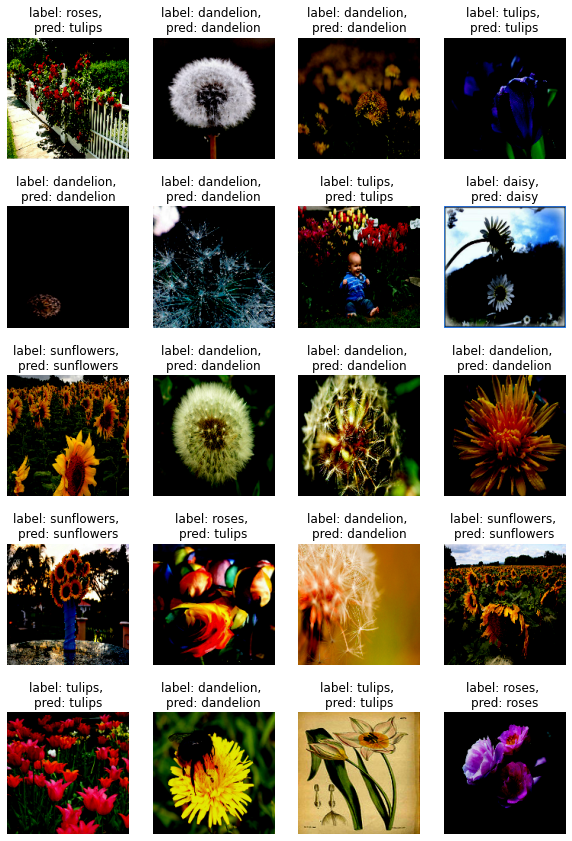

In [30]:
plt.figure(figsize=(10, 15))

for idx, (image, label) in enumerate(test.take(20)):
    plt.subplot(5, 4, idx+1)
    plt.imshow(image)
    plt.title(f'label: {get_label_name(label)}, \npred: {get_label_name(pred_label[idx])}')
    plt.axis('off')

In [31]:
count = 0
total = 0
for idx, (image, label) in enumerate(test.take(-1)):
    if label == pred_label[idx]:
        count += 1
    total += 1

test_accuracy = count/total

print(f'total test images: {total}, correct images: {count}, accuracy: {test_accuracy}')

total test images: 367, correct images: 336, accuracy: 0.9155313351498637


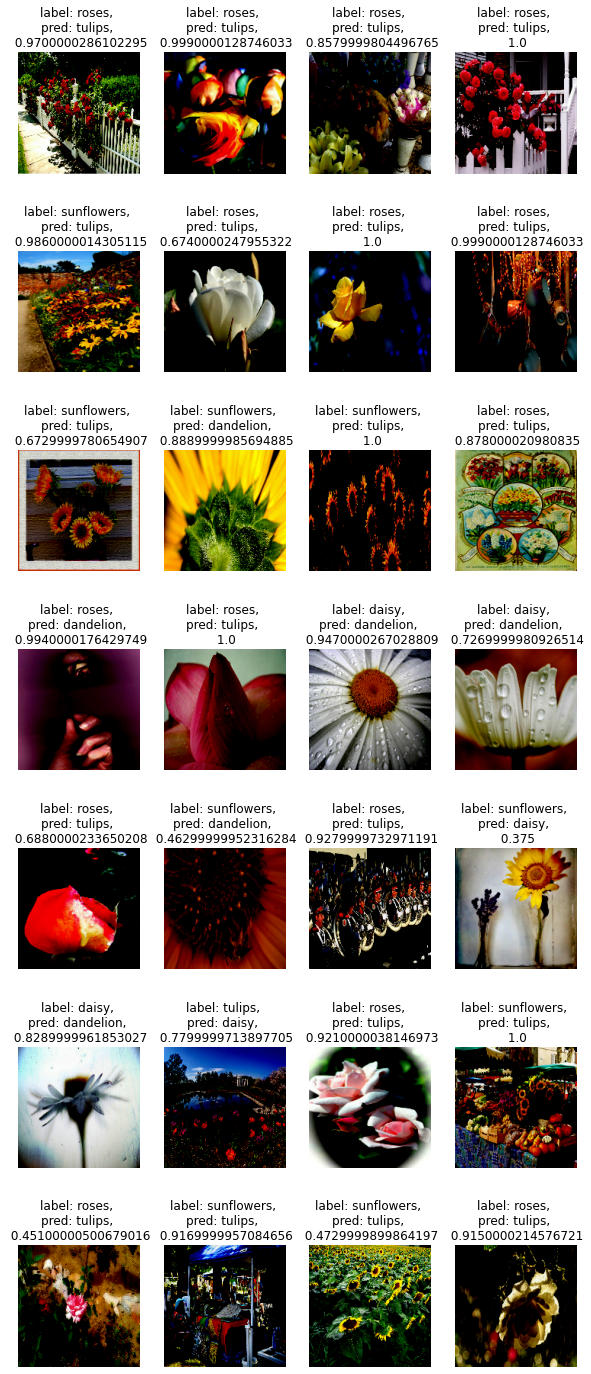

In [32]:
import numpy as np

i = 0
plt.figure(figsize=(10, 25))

for idx, (image, label) in enumerate(test.take(-1)):
    if label != pred_label[idx]:    
        plt.subplot(7, 4, i+1)
        plt.imshow(image)
        predicted_label = pred_label[idx]
        probability = pred[idx][predicted_label]
        plt.title(f'label: {get_label_name(label)}, \npred: {get_label_name(predicted_label)}, \n {round(probability, 3)}')
        plt.axis('off')
        i += 1
        if i == 28:
            break
plt.show()

### Step 6. 모델 활용하기

In [37]:
!ln -s ~/data/* ~/aiffel/tf_flowers/flowersImages/
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/flowersImages/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/flowersImages/cats_vs_dogs': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/flowersImages/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/tf_flowers/flowersImages/my_dog.jpg': File exists


In [38]:
IMG_SIZE = 160
img_dir_path = os.getenv("HOME") + "/aiffel/tf_flowers/flowersImages"
sun_flowers_path = os.path.join(img_dir_path, 'sun_flowers.jpeg')

sun_flowers = load_img(sun_flowers_path, target_size=(IMG_SIZE, IMG_SIZE))
sun_flowers

sun_flowers = img_to_array(sun_flowers).reshape(1, IMG_SIZE, IMG_SIZE, 3)
sun_flowers.shape

(1, 160, 160, 3)

In [39]:
prediction = model.predict(sun_flowers)
prediction

array([[3.9863817e-02, 2.8249767e-02, 9.2896789e-01, 2.9181859e-03,
        3.1795034e-07]], dtype=float32)

In [46]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    dandelion = round(prediction[0] * 100)
    daisy = round(prediction[1] * 100)
    tulips = round(prediction[2] * 100)
    sunflowers = round(prediction[3] * 100)
    roses = round(prediction[4] * 100)
    print(f'prediction: {prediction}')

prediction: [3.9863817e-02 2.8249767e-02 9.2896789e-01 2.9181859e-03 3.1795034e-07]


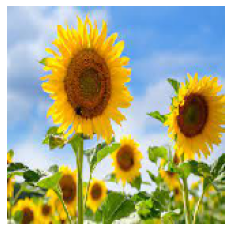

In [47]:
filename = 'sun_flowers.jpeg'

show_and_predict_image(img_dir_path, filename)

In [ ]:
filename = 'https://ifh.cc/g/nkPrB7.jpg'

show_and_predict_image(img_dir_path, filename)